# **Neural Machine Translation using Seq2Seq Modelling using PyTorch**


**Data Exploration Preprocessing**:  
* Pre-processing LinCE dataset (done)  
* Storing dataset in Pytorch format (done)

**Translation:**  
* Converting English to Hinglish i.e. Code-mixed data  

* Studying encoder-decoder architecture  

* Creating the translation model  

* Hyper parameter tuning  

* Metric Analysis with perplexity, and other scores like BLEU  

* Pre-trained embedding performance like glove


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/code-mix-generation-main

/content/drive/MyDrive/Colab Notebooks/code-mix-generation-main


## HEADER

In [3]:
!pip install torchtext==0.6.0 --quiet
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import  Field, TabularDataset, BucketIterator, Iterator
import numpy as np
import pandas as pd
import spacy
import random
from torchtext.data.metrics import bleu_score
from pprint import pprint
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
'''
# Seeding for reproducible results everytime
SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True'''

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00


'\n# Seeding for reproducible results everytime\nSEED = 777\n\nrandom.seed(SEED)\nnp.random.seed(SEED)\ntorch.manual_seed(SEED)\ntorch.cuda.manual_seed(SEED)\ntorch.backends.cudnn.deterministic = True'

In [ ]:
# !pip install -U torch==1.8.0 torchtext==0.9.0

# # Reload environment
# exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.8.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch==1.8.0


## Data Preparation & Pre-processing

In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [5]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.5 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=d828dc5ed25fee9074daa97e7a35ac00619bb060320943be2c9dabf54b3f3fdd
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [6]:
!python -m spacy download en --quiet

2023-05-05 15:11:13.104383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
!python -m spacy download en_core_web_sm

2023-05-05 15:11:35.359436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
spacy_english = spacy.load("en_core_web_sm")

In [9]:
def tokenize_english(text):
  return [token.text for token in spacy_english.tokenizer(text)]

In [10]:
# Define the input and output fields
SRC = Field(tokenize= tokenize_english, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize='moses', tokenizer_language='en-hi', init_token='<sos>', eos_token='<eos>', lower=True)

# Define the fields of the dataset
fields = {'src': ('src', SRC), 'trg': ('trg', TRG)}

In [12]:
# Load the dataset
train_data, valid_data = TabularDataset.splits(path='./mt_enghinglish', train='train.txt', validation='dev.txt', format='tsv', fields=fields)

# Build the vocabularies
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)
src_pad_idx = SRC.vocab.stoi[SRC.pad_token]
trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]

In [13]:
print(f"Unique tokens in source (en) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en-hi) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (en) vocabulary: 3823
Unique tokens in target (en-hi) vocabulary: 4893


In [26]:
print(TRG.vocab.__dict__.keys())

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])


In [27]:
e = list(TRG.vocab.__dict__.values())
for i in e:
  print(i)

Counter({'hai': 4272, ',': 2619, '.': 2363, 'ke': 1697, 'ki': 1667, 'mein': 1619, '?': 1588, 'ko': 1293, 'aur': 1228, 'hein': 1188, 'kya': 1169, 'movie': 1137, 'mujhe': 1040, 'nahi': 1016, 'ka': 955, 'tha': 875, 'se': 845, 'ek': 815, 'ye': 804, 'tho': 792, 'me': 789, 'bhi': 743, 'main': 658, 'wo': 654, 'bahut': 637, 'pasand': 572, 'ho': 533, 'kiya': 530, 'muje': 530, 'is': 507, 'liye': 503, 'hi': 489, 'haan': 478, 'hain': 471, '!': 468, 'yeh': 464, 'kar': 444, 'voh': 424, 'ne': 420, 'jo': 389, 'aap': 379, 'kuch': 367, 'to': 366, 'yah': 363, 'par': 362, 'lekin': 345, 'he': 343, 'lagta': 340, 'baare': 335, '..': 333, 'nahin': 297, 'the': 292, 'raha': 289, 'film': 274, 'us': 273, 'karne': 263, 'hoon': 262, 'tum': 261, 'movies': 255, 'karta': 255, 'jab': 249, 'thi': 242, 'hu': 228, 'laga': 227, 'dekha': 226, 'k': 216, 'maine': 214, 'acha': 212, 'gaya': 209, 'use': 207, 'tarah': 205, 'i': 204, 'mai': 198, 'tumhe': 196, 'woh': 190, 'ise': 184, 'koi': 183, '&quot;': 169, 'mere': 168, 'uska': 

In [28]:
word_2_idx = dict(e[3])
idx_2_word = {}
for k,v in word_2_idx.items():
  idx_2_word[v] = k

In [29]:
word_2_idx

{'<unk>': 0,
 '<pad>': 1,
 '<sos>': 2,
 '<eos>': 3,
 'hai': 4,
 ',': 5,
 '.': 6,
 'ke': 7,
 'ki': 8,
 'mein': 9,
 '?': 10,
 'ko': 11,
 'aur': 12,
 'hein': 13,
 'kya': 14,
 'movie': 15,
 'mujhe': 16,
 'nahi': 17,
 'ka': 18,
 'tha': 19,
 'se': 20,
 'ek': 21,
 'ye': 22,
 'tho': 23,
 'me': 24,
 'bhi': 25,
 'main': 26,
 'wo': 27,
 'bahut': 28,
 'pasand': 29,
 'ho': 30,
 'kiya': 31,
 'muje': 32,
 'is': 33,
 'liye': 34,
 'hi': 35,
 'haan': 36,
 'hain': 37,
 '!': 38,
 'yeh': 39,
 'kar': 40,
 'voh': 41,
 'ne': 42,
 'jo': 43,
 'aap': 44,
 'kuch': 45,
 'to': 46,
 'yah': 47,
 'par': 48,
 'lekin': 49,
 'he': 50,
 'lagta': 51,
 'baare': 52,
 '..': 53,
 'nahin': 54,
 'the': 55,
 'raha': 56,
 'film': 57,
 'us': 58,
 'karne': 59,
 'hoon': 60,
 'tum': 61,
 'karta': 62,
 'movies': 63,
 'jab': 64,
 'thi': 65,
 'hu': 66,
 'laga': 67,
 'dekha': 68,
 'k': 69,
 'maine': 70,
 'acha': 71,
 'gaya': 72,
 'use': 73,
 'tarah': 74,
 'i': 75,
 'mai': 76,
 'tumhe': 77,
 'woh': 78,
 'ise': 79,
 'koi': 80,
 '&quot;': 81

## Data Visualization

In [30]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")

Number of training examples: 8060
Number of validation examples: 942


In [31]:
print(train_data[0].__dict__.keys())
print(train_data[0].__dict__.values())

dict_keys(['src', 'trg'])
dict_values([['batman', 'vs', 'superman'], ['batman', 'vs', 'superman']])


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

train_iterator, valid_iterator = BucketIterator.splits((train_data, valid_data), 
                                                                      batch_size = BATCH_SIZE, 
                                                                      sort_within_batch=True,
                                                                      sort_key=lambda x: len(x.src),
                                                                      device = device)

In [33]:
max_len_eng = []
max_len_hing = []
for data in train_data:
  max_len_eng.append(len(data.src))
  max_len_hing.append(len(data.trg))

print("Maximum Length of English sentence = {} and Hinglish sentence = {} in the dataset".format(max(max_len_eng),max(max_len_hing)))
print("Minimum Length of English sentence = {} and Hinglish sentence = {} in the dataset".format(min(max_len_eng),min(max_len_hing)))

Maximum Length of English sentence = 291 and Hinglish sentence = 369 in the dataset
Minimum Length of English sentence = 1 and Hinglish sentence = 1 in the dataset


In [34]:
count = 0
for data in train_iterator:
  if count < 1 :
    print("Shapes", data.src.shape, data.trg.shape)
    print()
    print("English - ",*data.src, " Length - ", len(data.src))
    print()
    print("Hinglish - ",*data.trg, " Length - ", len(data.trg))
    temp_eng = data.src
    temp_hing = data.trg
    count += 1

Shapes torch.Size([293, 32]) torch.Size([371, 32])

English -  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0') tensor([ 104,    6,   56,   40,   42,    6,    6,    6,  664,   34,    6,   56,
          48,    5,  203,  911,    6,    5,  429,   56, 3305,    6,    6,    6,
           6,   58,   56,    6,  685,   42,    5,    6], device='cuda:0') tensor([2272,   30,    8,    9,    8,  495,   25,   97,   76,  899,   97,   11,
          54, 1258,  404,   85,   50,  112,    8,   14,    4,   86,   86,   97,
          98,  307,    8,   21,  220,    8,  264,   23], device='cuda:0') tensor([   9,   13,    7,  672,   59,  140,   87,  966,   38,    8,  502,   45,
          11,   15,    4,  632,   79,  415,    6,   25,    6,    4,    4,   39,
        1376,  268, 1590,   11, 1288,    5,   66,   29], device='cuda:0') tensor([1055, 2373,  808,    8,    5,   58,  336,   13,   29,   18,  350,  533,
           7,  254,    6,

In [35]:
temp_eng_idx = (temp_eng).cpu().detach().numpy()
temp_hing_idx = (temp_hing).cpu().detach().numpy()

In [36]:
df_hing_idx = pd.DataFrame(data = temp_hing_idx, columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_hing_idx.index.name = 'Time Steps'
df_hing_idx.index = df_hing_idx.index + 1 
df_hing_idx.to_csv('output/hing_idx.csv')
df_hing_idx

,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,S_10,...,S_23,S_24,S_25,S_26,S_27,S_28,S_29,S_30,S_31,S_32
Time Steps,,,,,,,,,,,,,,,,,,,,,
1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,0,32,455,182,36,26,32,128,4823,104,...,9,16,9,925,243,375,774,119,2195,76
3,21,129,5,642,5,271,45,0,25,2005,...,357,95,23,116,5,1827,1220,5,974,1106
4,0,13,251,43,120,1567,406,110,117,97,...,60,157,235,0,2030,7,2859,2770,82,1189
5,4611,8,0,1001,7,235,17,8,1987,0,...,53,4,7,1007,12,52,4,0,139,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,73,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
368,1001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
369,431,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [37]:
df_hing_word = pd.DataFrame(columns = [str("S_")+str(x) for x in np.arange(1, 33)])
df_hing_word = df_hing_idx.replace(idx_2_word)
df_hing_word.to_csv('output/hing_words.csv')
df_hing_word

,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,S_10,...,S_23,S_24,S_25,S_26,S_27,S_28,S_29,S_30,S_31,S_32
Time Steps,,,,,,,,,,,,,,,,,,,,,
1,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,...,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>,<sos>
2,commercially,muje,waise,bruce,haan,main,muje,mera,vise,ache,...,mein,mujhe,mein,dekho,well,un,luthor,han,dastaavez,mai
3,ek,lagtha,",",wayne,",",isse,kuch,commercially,bhi,question,...,maantha,pata,tho,tumne,",",cheejon,arrest,",",sirph,award
4,commercially,hein,it,jo,philm,bure,idea,ha,usne,kaafi,...,hoon,nhi,reviews,commercially,saverin,ke,hojata,editor,mere,shows
5,shipment,ki,commercially,bacha,ke,reviews,nahi,ki,philam,commercially,...,..,hai,ke,bola,aur,baare,hai,commercially,lie,pe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,use,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>
368,bacha,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>
369,leta,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>


## Encoder

In [39]:
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super(EncoderLSTM, self).__init__()

    # Size of the one hot vectors that will be the input to the encoder
    #self.input_size = input_size

    # Output size of the word embedding NN
    #self.embedding_size = embedding_size

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size

    # Number of layers in the lstm
    self.num_layers = num_layers

    # Regularization parameter
    self.dropout = nn.Dropout(p)
    self.tag = True

    # Shape --------------------> (5376, 300) [input size, embedding dims]
    self.embedding = nn.Embedding(input_size, embedding_size)
    
    # Shape -----------> (300, 2, 1024) [embedding dims, hidden size, num layers]
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

  # Shape of x (26, 32) [Sequence_length, batch_size]
  def forward(self, x):

    # Shape -----------> (26, 32, 300) [Sequence_length , batch_size , embedding dims]
    embedding = self.dropout(self.embedding(x))
    
    # Shape --> outputs (26, 32, 1024) [Sequence_length , batch_size , hidden_size]
    # Shape --> (hs, cs) (2, 32, 1024) , (2, 32, 1024) [num_layers, batch_size size, hidden_size]
    outputs, (hidden_state, cell_state) = self.LSTM(embedding)

    return hidden_state, cell_state

input_size_encoder = len(SRC.vocab)
encoder_embedding_size = 300
hidden_size = 1024
num_layers = 2
encoder_dropout = 0.5

encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, encoder_dropout).to(device)
print(encoder_lstm)

EncoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(3823, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
)


## Decoder

In [41]:
class DecoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
    super(DecoderLSTM, self).__init__()

    # Size of the one hot vectors that will be the input to the encoder
    #self.input_size = input_size

    # Output size of the word embedding NN
    #self.embedding_size = embedding_size

    # Dimension of the NN's inside the lstm cell/ (hs,cs)'s dimension.
    self.hidden_size = hidden_size

    # Number of layers in the lstm
    self.num_layers = num_layers

    # Size of the one hot vectors that will be the output to the encoder (English Vocab Size)
    self.output_size = output_size

    # Regularization parameter
    self.dropout = nn.Dropout(p)

    # Shape --------------------> (5376, 300) [input size, embedding dims]
    self.embedding = nn.Embedding(input_size, embedding_size)

    # Shape -----------> (300, 2, 1024) [embedding dims, hidden size, num layers]
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

    # Shape -----------> (1024, 4556) [embedding dims, hidden size, num layers]
    self.fc = nn.Linear(hidden_size, output_size)

  # Shape of x (32) [batch_size]
  def forward(self, x, hidden_state, cell_state):

    # Shape of x (1, 32) [1, batch_size]
    x = x.unsqueeze(0)

    # Shape -----------> (1, 32, 300) [1, batch_size, embedding dims]
    embedding = self.dropout(self.embedding(x))

    # Shape --> outputs (1, 32, 1024) [1, batch_size , hidden_size]
    # Shape --> (hs, cs) (2, 32, 1024) , (2, 32, 1024) [num_layers, batch_size size, hidden_size] (passing encoder's hs, cs - context vectors)
    outputs, (hidden_state, cell_state) = self.LSTM(embedding, (hidden_state, cell_state))

    # Shape --> predictions (1, 32, 4556) [ 1, batch_size , output_size]
    predictions = self.fc(outputs)

    # Shape --> predictions (32, 4556) [batch_size , output_size]
    predictions = predictions.squeeze(0)

    return predictions, hidden_state, cell_state

input_size_decoder = len(TRG.vocab)
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 2
decoder_dropout = 0.5
output_size = len(TRG.vocab)

decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size, hidden_size, num_layers, decoder_dropout, output_size).to(device)
print(decoder_lstm)

DecoderLSTM(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(4893, 300)
  (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=4893, bias=True)
)


In [42]:
for batch in train_iterator:
  print(batch.src.shape)
  print(batch.trg.shape)
  break

x = batch.trg[1]
print(x)

torch.Size([3, 32])
torch.Size([5, 32])
tensor([ 526,   36, 2852,   14, 1299,   47, 1785,  106,   35,  883,  110,   36,
          35, 4815,  106,   10,  106,   98,  178,  106,   35,  153,  106,  192,
          35, 4844,  119,  258,   10,  563,  228,   35], device='cuda:0')


## Seq2Seq (Encoder + Decoder)

In [43]:
class Seq2Seq(nn.Module):
  def __init__(self, Encoder_LSTM, Decoder_LSTM):
    super(Seq2Seq, self).__init__()
    self.Encoder_LSTM = Encoder_LSTM
    self.Decoder_LSTM = Decoder_LSTM

  def forward(self, source, target, tfr=0.5):
    # Shape - Source : (10, 32) [(Sentence length German + some padding), Number of Sentences]
    batch_size = source.shape[1]

    # Shape - Source : (14, 32) [(Sentence length English + some padding), Number of Sentences]
    target_len = target.shape[0]
    target_vocab_size = len(TRG.vocab)
    
    # Shape --> outputs (14, 32, 5766) 
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

    # Shape --> (hs, cs) (2, 32, 1024) ,(2, 32, 1024) [num_layers, batch_size size, hidden_size] (contains encoder's hs, cs - context vectors)
    hidden_state, cell_state = self.Encoder_LSTM(source)

    # Shape of x (32 elements)
    x = target[0] # Trigger token <SOS>

    for i in range(1, target_len):
      # Shape --> output (32, 5766) 
      output, hidden_state, cell_state = self.Decoder_LSTM(x, hidden_state, cell_state)
      outputs[i] = output
      best_guess = output.argmax(1) # 0th dimension is batch size, 1st dimension is word embedding
      x = target[i] if random.random() < tfr else best_guess # Either pass the next word correctly from the dataset or use the earlier predicted word

    # Shape --> outputs (14, 32, 5766) 
    return outputs


In [44]:
# Hyperparameters

learning_rate = 0.001
writer = SummaryWriter(f"runs/loss_plot")
step = 0

model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = TRG.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [45]:
model

Seq2Seq(
  (Encoder_LSTM): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(3823, 300)
    (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
  )
  (Decoder_LSTM): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(4893, 300)
    (LSTM): LSTM(300, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=4893, bias=True)
  )
)

In [46]:
def translate_sentence(model, sentence,english,hinglish, device, max_length=50):
    spacy_eng = spacy.load("en_core_web_sm")

    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_eng(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, english.init_token)
    tokens.append(english.eos_token)
    text_to_indices = [english.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        hidden, cell = model.Encoder_LSTM(sentence_tensor)

    outputs = [hinglish.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.Decoder_LSTM(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == hinglish.vocab.stoi["<eos>"]:
            break

    translated_sentence = [hinglish.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]

def bleu(data, model, english,hinglish, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, english,hinglish, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)

def checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss):
    print('saving')
    print()
    state = {'model': model,'best_loss': best_loss,'epoch': epoch,'rng_state': torch.get_rng_state(), 'optimizer': optimizer.state_dict(),}
    torch.save(state, 'output/checkpoint-NMT')
    torch.save(model.state_dict(),'output/checkpoint-NMT-SD')

## Seq2Seq Model Training

In [52]:
epoch_loss = 0.0
num_epochs = 20
best_loss = 999999
best_epoch = -1
sentence1 = "i know the difference"
ts1  = []
epoch_losses = []
for epoch in range(num_epochs):
  print("Epoch - {} / {}".format(epoch+1, num_epochs))
  model.eval()
  translated_sentence1 = translate_sentence(model, sentence1, SRC, TRG, device, max_length=50)
  print(f"Translated example sentence 1: \n {translated_sentence1}")
  ts1.append(translated_sentence1)

  model.train(True)
  for batch_idx, batch in enumerate(train_iterator):
    input = batch.src.to(device)
    target = batch.trg.to(device)

    # Pass the input and target for model's forward method
    output = model(input, target)
    output = output[1:].reshape(-1, output.shape[2])
    target = target[1:].reshape(-1)

    # Clear the accumulating gradients
    optimizer.zero_grad()

    # Calculate the loss value for every epoch
    loss = criterion(output, target)

    # Calculate the gradients for weights & biases using back-propagation
    loss.backward()

    # Clip the gradient value is it exceeds > 1
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    # Update the weights values using the gradients we calculated using bp 
    optimizer.step()
    step += 1
    epoch_loss += loss.item()
    writer.add_scalar("Training loss", loss, global_step=step)

  if epoch_loss < best_loss:
    best_loss = epoch_loss
    best_epoch = epoch
    checkpoint_and_save(model, best_loss, epoch, optimizer, epoch_loss) 
    if ((epoch - best_epoch) >= 10):
      print("no improvement in 10 epochs, break")
      break
  print("Epoch_Loss = {}".format(loss.item()))
  epoch_losses.append(loss.item())
  print()
  
print(epoch_loss / len(train_iterator))


Epoch - 1 / 20
Translated example sentence 1: 
 ['mujhe', 'laga', 'hai', 'mustangs', '<eos>']
saving

Epoch_Loss = 1.9689141511917114

Epoch - 2 / 20
Translated example sentence 1: 
 ['muje', 'bhi', 'aise', 'hi', 'laga', '<eos>']
Epoch_Loss = 1.7652822732925415

Epoch - 3 / 20
Translated example sentence 1: 
 ['mujhe', 'pata', 'hai', 'ki', '<eos>']
Epoch_Loss = 1.062523365020752

Epoch - 4 / 20
Translated example sentence 1: 
 ['mujhe', 'lgta', 'hai', 'aisa', 'laga', '<eos>']
Epoch_Loss = 1.53066086769104

Epoch - 5 / 20
Translated example sentence 1: 
 ['muje', 'bhi', 'kuch', 'aise', 'hi', 'laga', '<eos>']
Epoch_Loss = 4.017604351043701

Epoch - 6 / 20
Translated example sentence 1: 
 ['mujhe', 'bhi', 'kuch', 'aise', 'hi', 'laga', '<eos>']
Epoch_Loss = 1.7632946968078613

Epoch - 7 / 20
Translated example sentence 1: 
 ['mujhe', 'laga', 'ki', 'bahut', 'pasand', 'hein', '<eos>']
Epoch_Loss = 1.7939538955688477

Epoch - 8 / 20
Translated example sentence 1: 
 ['mujhe', 'bhi', 'hai', 'mu

In [55]:
score = bleu(valid_data, model, SRC, TRG, device)
print(f"Bleu score = {score*100:.2f}")

Bleu score = 1.38


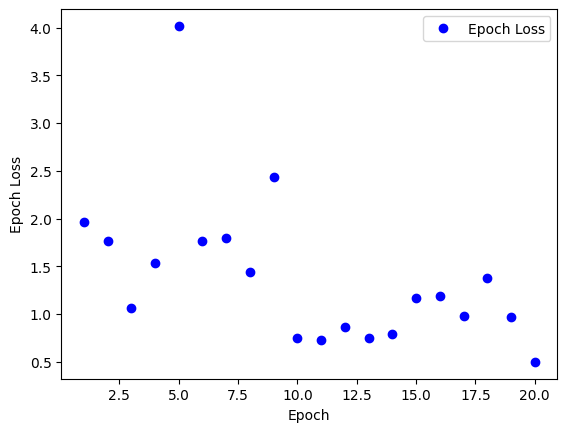

In [53]:
import matplotlib.pyplot as plt

# Generate x-axis values for the graph
epochs = range(1, len(epoch_losses) + 1)

# Plot the epoch loss values
plt.plot(epochs, epoch_losses, 'bo', label='Epoch Loss')

# Add axis labels and legend
plt.xlabel('Epoch')
plt.ylabel('Epoch Loss')
plt.legend()

# Show the plot
plt.show()

In [54]:
from prettytable import PrettyTable

# Create a new table with one column
table = PrettyTable()
table.field_names = ["Epochs","Loss"]

# Add some rows of data
for i in range(len(epoch_losses)):
    table.add_row([i+1, epoch_losses[i]])

# Print the table
print(table)


+--------+---------------------+
| Epochs |         Loss        |
+--------+---------------------+
|   1    |  1.9689141511917114 |
|   2    |  1.7652822732925415 |
|   3    |  1.062523365020752  |
|   4    |   1.53066086769104  |
|   5    |  4.017604351043701  |
|   6    |  1.7632946968078613 |
|   7    |  1.7939538955688477 |
|   8    |  1.436180591583252  |
|   9    |  2.4345710277557373 |
|   10   |  0.7464218735694885 |
|   11   |  0.7255614995956421 |
|   12   |  0.8602990508079529 |
|   13   |  0.7542532682418823 |
|   14   |  0.786764919757843  |
|   15   |  1.1678128242492676 |
|   16   |  1.1889249086380005 |
|   17   |  0.9799388647079468 |
|   18   |  1.3740839958190918 |
|   19   |  0.9729033708572388 |
|   20   | 0.49897074699401855 |
+--------+---------------------+


## Model Inference

In [49]:
progress  = []
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
for i, sen in enumerate(ts1):
  progress.append(TreebankWordDetokenizer().detokenize(sen))
print(progress)

['rileej prasiddh prasiddh prasiddh without filmon diamond jail jail hume,, huya bharosa khyaal khyaal kahani kahani khyaal kahani jeff prasiddh prasiddh sexual lagatee jeetane mool mool jinase chalti chalti deserve jeetane mool mool moments jinase selection kahani prasiddh prasiddh bahen diamond kabi jail hume,, luhrmann bharosa', 'kya, hai <eos>', 'mujhe bhi hai <eos>', 'mujhe bhi nahi hoon <eos>', 'mujhe bhi pasand pasand hai <eos>', 'mujhe bhi pasand pasand <eos>', 'mujhe bhi pasand pasand <eos>', 'mujhe bhi pasand pasand <eos>', 'mujhe bhi pasand hai <eos>', 'mujhe <unk> pasand hai <eos>', 'mujhe difference pasand hai <eos>', 'mujhe difference hai mustangs <eos>', 'mujhe <unk> pasand hai <eos>', 'mujhe lgta hai mustangs <eos>', 'muje bhi aise hi laga <eos>', 'mujhe pata hai mustangs <eos>', 'mujhe difference hai mustangs <eos>', 'mujhe laga hai mustangs <eos>', 'mujhe bhi hai mustangs <eos>', 'mujhe laga ki bahut like tha <eos>']


In [50]:
progress_df = pd.DataFrame(data = progress, columns=['Predicted Sentence'])
progress_df.index.name = "Epochs"
progress_df.to_csv('output/predicted_sentence.csv')
progress_df.head()

,Predicted Sentence
Epochs,
0,rileej prasiddh prasiddh prasiddh without film...
1,"kya, hai <eos>"
2,mujhe bhi hai <eos>
3,mujhe bhi nahi hoon <eos>
4,mujhe bhi pasand pasand hai <eos>


In [51]:
model.eval()
test_sentences  = ["Alright that is fine. What is the movie?", "The movie is The Social Network", "I have not seen that one either.","may be worth watching!"]
actual_sentences  = ["acha tho is movie kis baare me hein?", "is movie tho social network ke bare mein hein", "mein aise kuch nahi dekha hoon","haan worth watching hein"]
pred_sentences = []

for idx, i in enumerate(test_sentences):
  model.eval()
  translated_sentence = translate_sentence(model, i, SRC, TRG, device, max_length=50)
  progress.append(TreebankWordDetokenizer().detokenize(translated_sentence))
  print("English : {}".format(i))
  print("Actual Sentence in Hinglish : {}".format(actual_sentences[idx]))
  print("Predicted Sentence in Hinglish : {}".format(progress[-1]))
  print()

English : Alright that is fine. What is the movie?
Actual Sentence in Hinglish : acha tho is movie kis baare me hein?
Predicted Sentence in Hinglish : interesting hai kya ye ek long movie hai? <eos>

English : The movie is The Social Network
Actual Sentence in Hinglish : is movie tho social network ke bare mein hein
Predicted Sentence in Hinglish : movie ka name hai hai <eos>

English : I have not seen that one either.
Actual Sentence in Hinglish : mein aise kuch nahi dekha hoon
Predicted Sentence in Hinglish : maine kabhi nahi dekhi <eos>

English : may be worth watching!
Actual Sentence in Hinglish : haan worth watching hein
Predicted Sentence in Hinglish : do box bhi man! <eos>

